# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.SELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): SELU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): SELU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): SELU()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.7955
Epoch 1/200, Iteration 2/12, Loss: 2.4576
Epoch 1/200, Iteration 3/12, Loss: 2.4466
Epoch 1/200, Iteration 4/12, Loss: 1.7919
Epoch 1/200, Iteration 5/12, Loss: 1.1953
Epoch 1/200, Iteration 6/12, Loss: 0.6029
Epoch 1/200, Iteration 7/12, Loss: 0.8171
Epoch 1/200, Iteration 8/12, Loss: 1.0080
Epoch 1/200, Iteration 9/12, Loss: 0.5705
Epoch 1/200, Iteration 10/12, Loss: 0.6515
Epoch 1/200, Iteration 11/12, Loss: 0.7814
Epoch 1/200, Iteration 12/12, Loss: 0.6383
Epoch 1/200, Iteration 13/12, Loss: 0.4396
Train Error: 
 Accuracy: 73.75%, Avg loss: 0.352825, MRE: 0.294035, MAE: 0.052818 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.360887, MRE: 0.270452, MAE: 0.053819 

Epoch 2/200, Iteration 1/12, Loss: 0.3554
Epoch 2/200, Iteration 2/12, Loss: 0.4161
Epoch 2/200, Iteration 3/12, Loss: 0.3574
Epoch 2/200, Iteration 4/12, Loss: 0.3713
Epoch 2/200, Iteration 5/12, Loss: 0.3640
Epoch 2/200, Iteration 6/12, Loss: 0.3214
Epoch 2/200, Iteration 7/12, Los

Epoch 12/200, Iteration 10/12, Loss: 0.1094
Epoch 12/200, Iteration 11/12, Loss: 0.1039
Epoch 12/200, Iteration 12/12, Loss: 0.0957
Epoch 12/200, Iteration 13/12, Loss: 0.1513
Train Error: 
 Accuracy: 76.38%, Avg loss: 0.129007, MRE: 0.117854, MAE: 0.015102 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.127690, MRE: 0.107254, MAE: 0.014988 

Epoch 13/200, Iteration 1/12, Loss: 0.1254
Epoch 13/200, Iteration 2/12, Loss: 0.1351
Epoch 13/200, Iteration 3/12, Loss: 0.1680
Epoch 13/200, Iteration 4/12, Loss: 0.1167
Epoch 13/200, Iteration 5/12, Loss: 0.1424
Epoch 13/200, Iteration 6/12, Loss: 0.1796
Epoch 13/200, Iteration 7/12, Loss: 0.1272
Epoch 13/200, Iteration 8/12, Loss: 0.1038
Epoch 13/200, Iteration 9/12, Loss: 0.1761
Epoch 13/200, Iteration 10/12, Loss: 0.1993
Epoch 13/200, Iteration 11/12, Loss: 0.0859
Epoch 13/200, Iteration 12/12, Loss: 0.1134
Epoch 13/200, Iteration 13/12, Loss: 0.1363
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.098632, MRE: 0.071437, MAE: 0.013111 

Test Error:

Train Error: 
 Accuracy: 62.75%, Avg loss: 0.115726, MRE: 0.106816, MAE: 0.013959 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.107328, MRE: 0.084810, MAE: 0.013097 

Epoch 24/200, Iteration 1/12, Loss: 0.1323
Epoch 24/200, Iteration 2/12, Loss: 0.1107
Epoch 24/200, Iteration 3/12, Loss: 0.1197
Epoch 24/200, Iteration 4/12, Loss: 0.1186
Epoch 24/200, Iteration 5/12, Loss: 0.1345
Epoch 24/200, Iteration 6/12, Loss: 0.1110
Epoch 24/200, Iteration 7/12, Loss: 0.1012
Epoch 24/200, Iteration 8/12, Loss: 0.1016
Epoch 24/200, Iteration 9/12, Loss: 0.1070
Epoch 24/200, Iteration 10/12, Loss: 0.0985
Epoch 24/200, Iteration 11/12, Loss: 0.1037
Epoch 24/200, Iteration 12/12, Loss: 0.0895
Epoch 24/200, Iteration 13/12, Loss: 0.0653
Train Error: 
 Accuracy: 80.25%, Avg loss: 0.097801, MRE: 0.075090, MAE: 0.011790 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.098775, MRE: 0.064386, MAE: 0.011685 

Epoch 25/200, Iteration 1/12, Loss: 0.1052
Epoch 25/200, Iteration 2/12, Loss: 0.1281
Epoch 25/200, Itera

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.120162, MRE: 0.088027, MAE: 0.019035 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.120416, MRE: 0.072045, MAE: 0.019071 

Epoch 36/200, Iteration 1/12, Loss: 0.1209
Epoch 36/200, Iteration 2/12, Loss: 0.1187
Epoch 36/200, Iteration 3/12, Loss: 0.0731
Epoch 36/200, Iteration 4/12, Loss: 0.1041
Epoch 36/200, Iteration 5/12, Loss: 0.0614
Epoch 36/200, Iteration 6/12, Loss: 0.1078
Epoch 36/200, Iteration 7/12, Loss: 0.1118
Epoch 36/200, Iteration 8/12, Loss: 0.0753
Epoch 36/200, Iteration 9/12, Loss: 0.1127
Epoch 36/200, Iteration 10/12, Loss: 0.0825
Epoch 36/200, Iteration 11/12, Loss: 0.0923
Epoch 36/200, Iteration 12/12, Loss: 0.1252
Epoch 36/200, Iteration 13/12, Loss: 0.1104
Train Error: 
 Accuracy: 90.75%, Avg loss: 0.058876, MRE: 0.039258, MAE: 0.007147 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.052698, MRE: 0.031666, MAE: 0.006669 

Epoch 37/200, Iteration 1/12, Loss: 0.0707
Epoch 37/200, Iteration 2/12, Loss: 0.1053
Epoch 37/200, Iterat

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.120062, MRE: 0.096943, MAE: 0.015524 

Epoch 48/200, Iteration 1/12, Loss: 0.1184
Epoch 48/200, Iteration 2/12, Loss: 0.1312
Epoch 48/200, Iteration 3/12, Loss: 0.1020
Epoch 48/200, Iteration 4/12, Loss: 0.0902
Epoch 48/200, Iteration 5/12, Loss: 0.0606
Epoch 48/200, Iteration 6/12, Loss: 0.0429
Epoch 48/200, Iteration 7/12, Loss: 0.0471
Epoch 48/200, Iteration 8/12, Loss: 0.0541
Epoch 48/200, Iteration 9/12, Loss: 0.0641
Epoch 48/200, Iteration 10/12, Loss: 0.0624
Epoch 48/200, Iteration 11/12, Loss: 0.0638
Epoch 48/200, Iteration 12/12, Loss: 0.0606
Epoch 48/200, Iteration 13/12, Loss: 0.0491
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.043165, MRE: 0.034840, MAE: 0.006021 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.042047, MRE: 0.026328, MAE: 0.005936 

Epoch 49/200, Iteration 1/12, Loss: 0.0488
Epoch 49/200, Iteration 2/12, Loss: 0.0535
Epoch 49/200, Iteration 3/12, Loss: 0.0422
Epoch 49/200, Iteration 4/12, Loss: 0.0492
Epoch 49/200, Ite

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.014382, MRE: 0.015180, MAE: 0.001901 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014143, MRE: 0.010572, MAE: 0.001840 

Epoch 60/200, Iteration 1/12, Loss: 0.0120
Epoch 60/200, Iteration 2/12, Loss: 0.0157
Epoch 60/200, Iteration 3/12, Loss: 0.0140
Epoch 60/200, Iteration 4/12, Loss: 0.0156
Epoch 60/200, Iteration 5/12, Loss: 0.0160
Epoch 60/200, Iteration 6/12, Loss: 0.0196
Epoch 60/200, Iteration 7/12, Loss: 0.0170
Epoch 60/200, Iteration 8/12, Loss: 0.0154
Epoch 60/200, Iteration 9/12, Loss: 0.0138
Epoch 60/200, Iteration 10/12, Loss: 0.0156
Epoch 60/200, Iteration 11/12, Loss: 0.0124
Epoch 60/200, Iteration 12/12, Loss: 0.0159
Epoch 60/200, Iteration 13/12, Loss: 0.0150
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.016166, MRE: 0.015056, MAE: 0.002224 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015318, MRE: 0.010040, MAE: 0.002086 

Epoch 61/200, Iteration 1/12, Loss: 0.0161
Epoch 61/200, Iteration 2/12, Loss: 0.0130
Epoch 61/200, Itera

Epoch 71/200, Iteration 2/12, Loss: 0.0171
Epoch 71/200, Iteration 3/12, Loss: 0.0134
Epoch 71/200, Iteration 4/12, Loss: 0.0140
Epoch 71/200, Iteration 5/12, Loss: 0.0121
Epoch 71/200, Iteration 6/12, Loss: 0.0117
Epoch 71/200, Iteration 7/12, Loss: 0.0092
Epoch 71/200, Iteration 8/12, Loss: 0.0133
Epoch 71/200, Iteration 9/12, Loss: 0.0128
Epoch 71/200, Iteration 10/12, Loss: 0.0124
Epoch 71/200, Iteration 11/12, Loss: 0.0105
Epoch 71/200, Iteration 12/12, Loss: 0.0128
Epoch 71/200, Iteration 13/12, Loss: 0.0102
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.011656, MRE: 0.012186, MAE: 0.001502 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012243, MRE: 0.008880, MAE: 0.001521 

Epoch 72/200, Iteration 1/12, Loss: 0.0115
Epoch 72/200, Iteration 2/12, Loss: 0.0150
Epoch 72/200, Iteration 3/12, Loss: 0.0126
Epoch 72/200, Iteration 4/12, Loss: 0.0118
Epoch 72/200, Iteration 5/12, Loss: 0.0104
Epoch 72/200, Iteration 6/12, Loss: 0.0133
Epoch 72/200, Iteration 7/12, Loss: 0.0137
Epoch 72/200

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.011785, MRE: 0.010807, MAE: 0.001568 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012799, MRE: 0.008551, MAE: 0.001721 

Epoch 83/200, Iteration 1/12, Loss: 0.0109
Epoch 83/200, Iteration 2/12, Loss: 0.0125
Epoch 83/200, Iteration 3/12, Loss: 0.0144
Epoch 83/200, Iteration 4/12, Loss: 0.0129
Epoch 83/200, Iteration 5/12, Loss: 0.0127
Epoch 83/200, Iteration 6/12, Loss: 0.0155
Epoch 83/200, Iteration 7/12, Loss: 0.0140
Epoch 83/200, Iteration 8/12, Loss: 0.0157
Epoch 83/200, Iteration 9/12, Loss: 0.0144
Epoch 83/200, Iteration 10/12, Loss: 0.0146
Epoch 83/200, Iteration 11/12, Loss: 0.0139
Epoch 83/200, Iteration 12/12, Loss: 0.0117
Epoch 83/200, Iteration 13/12, Loss: 0.0090
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.013681, MRE: 0.011900, MAE: 0.001892 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013942, MRE: 0.009685, MAE: 0.001869 

Epoch 84/200, Iteration 1/12, Loss: 0.0129
Epoch 84/200, Iteration 2/12, Loss: 0.0118
Epoch 84/200, Ite

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009298, MRE: 0.006595, MAE: 0.001174 

Epoch 95/200, Iteration 1/12, Loss: 0.0070
Epoch 95/200, Iteration 2/12, Loss: 0.0090
Epoch 95/200, Iteration 3/12, Loss: 0.0085
Epoch 95/200, Iteration 4/12, Loss: 0.0064
Epoch 95/200, Iteration 5/12, Loss: 0.0070
Epoch 95/200, Iteration 6/12, Loss: 0.0064
Epoch 95/200, Iteration 7/12, Loss: 0.0080
Epoch 95/200, Iteration 8/12, Loss: 0.0085
Epoch 95/200, Iteration 9/12, Loss: 0.0085
Epoch 95/200, Iteration 10/12, Loss: 0.0062
Epoch 95/200, Iteration 11/12, Loss: 0.0079
Epoch 95/200, Iteration 12/12, Loss: 0.0078
Epoch 95/200, Iteration 13/12, Loss: 0.0086
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007592, MRE: 0.008171, MAE: 0.000999 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009050, MRE: 0.006420, MAE: 0.001151 

Epoch 96/200, Iteration 1/12, Loss: 0.0083
Epoch 96/200, Iteration 2/12, Loss: 0.0097
Epoch 96/200, Iteration 3/12, Loss: 0.0068
Epoch 96/200, Iteration 4/12, Loss: 0.0077
Epoch 96/200, I

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007099, MRE: 0.007467, MAE: 0.000936 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008523, MRE: 0.006066, MAE: 0.001064 

Epoch 107/200, Iteration 1/12, Loss: 0.0067
Epoch 107/200, Iteration 2/12, Loss: 0.0108
Epoch 107/200, Iteration 3/12, Loss: 0.0077
Epoch 107/200, Iteration 4/12, Loss: 0.0074
Epoch 107/200, Iteration 5/12, Loss: 0.0066
Epoch 107/200, Iteration 6/12, Loss: 0.0069
Epoch 107/200, Iteration 7/12, Loss: 0.0083
Epoch 107/200, Iteration 8/12, Loss: 0.0067
Epoch 107/200, Iteration 9/12, Loss: 0.0068
Epoch 107/200, Iteration 10/12, Loss: 0.0067
Epoch 107/200, Iteration 11/12, Loss: 0.0074
Epoch 107/200, Iteration 12/12, Loss: 0.0077
Epoch 107/200, Iteration 13/12, Loss: 0.0057
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007430, MRE: 0.008157, MAE: 0.000966 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008679, MRE: 0.006342, MAE: 0.001081 

Epoch 108/200, Iteration 1/12, Loss: 0.0075
Epoch 108/200, Iteration 2/12, Loss: 0.0093
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007344, MRE: 0.007612, MAE: 0.000969 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008672, MRE: 0.006219, MAE: 0.001097 

Epoch 119/200, Iteration 1/12, Loss: 0.0070
Epoch 119/200, Iteration 2/12, Loss: 0.0088
Epoch 119/200, Iteration 3/12, Loss: 0.0068
Epoch 119/200, Iteration 4/12, Loss: 0.0065
Epoch 119/200, Iteration 5/12, Loss: 0.0057
Epoch 119/200, Iteration 6/12, Loss: 0.0083
Epoch 119/200, Iteration 7/12, Loss: 0.0068
Epoch 119/200, Iteration 8/12, Loss: 0.0076
Epoch 119/200, Iteration 9/12, Loss: 0.0080
Epoch 119/200, Iteration 10/12, Loss: 0.0068
Epoch 119/200, Iteration 11/12, Loss: 0.0071
Epoch 119/200, Iteration 12/12, Loss: 0.0082
Epoch 119/200, Iteration 13/12, Loss: 0.0069
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007409, MRE: 0.010118, MAE: 0.000989 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008504, MRE: 0.006159, MAE: 0.001073 

Epoch 120/200, Iteration 1/12, Loss: 0.0071
Epoch 120/200, Iteration 2/12, Loss: 0.0069
Ep

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009101, MRE: 0.006489, MAE: 0.001122 

Epoch 131/200, Iteration 1/12, Loss: 0.0075
Epoch 131/200, Iteration 2/12, Loss: 0.0073
Epoch 131/200, Iteration 3/12, Loss: 0.0071
Epoch 131/200, Iteration 4/12, Loss: 0.0061
Epoch 131/200, Iteration 5/12, Loss: 0.0079
Epoch 131/200, Iteration 6/12, Loss: 0.0081
Epoch 131/200, Iteration 7/12, Loss: 0.0062
Epoch 131/200, Iteration 8/12, Loss: 0.0085
Epoch 131/200, Iteration 9/12, Loss: 0.0059
Epoch 131/200, Iteration 10/12, Loss: 0.0069
Epoch 131/200, Iteration 11/12, Loss: 0.0059
Epoch 131/200, Iteration 12/12, Loss: 0.0073
Epoch 131/200, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007113, MRE: 0.007193, MAE: 0.000945 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008919, MRE: 0.006221, MAE: 0.001123 

Epoch 132/200, Iteration 1/12, Loss: 0.0060
Epoch 132/200, Iteration 2/12, Loss: 0.0063
Epoch 132/200, Iteration 3/12, Loss: 0.0060
Epoch 132/200, Iteration 4/12, Loss: 0.008

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006811, MRE: 0.007196, MAE: 0.000908 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008494, MRE: 0.006084, MAE: 0.001064 

Epoch 143/200, Iteration 1/12, Loss: 0.0059
Epoch 143/200, Iteration 2/12, Loss: 0.0069
Epoch 143/200, Iteration 3/12, Loss: 0.0057
Epoch 143/200, Iteration 4/12, Loss: 0.0052
Epoch 143/200, Iteration 5/12, Loss: 0.0068
Epoch 143/200, Iteration 6/12, Loss: 0.0064
Epoch 143/200, Iteration 7/12, Loss: 0.0061
Epoch 143/200, Iteration 8/12, Loss: 0.0089
Epoch 143/200, Iteration 9/12, Loss: 0.0071
Epoch 143/200, Iteration 10/12, Loss: 0.0057
Epoch 143/200, Iteration 11/12, Loss: 0.0071
Epoch 143/200, Iteration 12/12, Loss: 0.0064
Epoch 143/200, Iteration 13/12, Loss: 0.0124
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006572, MRE: 0.006918, MAE: 0.000868 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008196, MRE: 0.005758, MAE: 0.001033 

Epoch 144/200, Iteration 1/12, Loss: 0.0063
Epoch 144/200, Iteration 2/12, Loss: 0.0066
Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006719, MRE: 0.006879, MAE: 0.000868 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008300, MRE: 0.005765, MAE: 0.001050 

Epoch 155/200, Iteration 1/12, Loss: 0.0084
Epoch 155/200, Iteration 2/12, Loss: 0.0070
Epoch 155/200, Iteration 3/12, Loss: 0.0063
Epoch 155/200, Iteration 4/12, Loss: 0.0074
Epoch 155/200, Iteration 5/12, Loss: 0.0062
Epoch 155/200, Iteration 6/12, Loss: 0.0066
Epoch 155/200, Iteration 7/12, Loss: 0.0079
Epoch 155/200, Iteration 8/12, Loss: 0.0056
Epoch 155/200, Iteration 9/12, Loss: 0.0072
Epoch 155/200, Iteration 10/12, Loss: 0.0070
Epoch 155/200, Iteration 11/12, Loss: 0.0062
Epoch 155/200, Iteration 12/12, Loss: 0.0054
Epoch 155/200, Iteration 13/12, Loss: 0.0084
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006646, MRE: 0.006954, MAE: 0.000879 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008909, MRE: 0.006316, MAE: 0.001125 

Epoch 156/200, Iteration 1/12, Loss: 0.0097
Epoch 156/200, Iteration 2/12, Loss: 0.0068
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006454, MRE: 0.006525, MAE: 0.000837 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008315, MRE: 0.005796, MAE: 0.001046 

Epoch 167/200, Iteration 1/12, Loss: 0.0076
Epoch 167/200, Iteration 2/12, Loss: 0.0060
Epoch 167/200, Iteration 3/12, Loss: 0.0066
Epoch 167/200, Iteration 4/12, Loss: 0.0065
Epoch 167/200, Iteration 5/12, Loss: 0.0056
Epoch 167/200, Iteration 6/12, Loss: 0.0067
Epoch 167/200, Iteration 7/12, Loss: 0.0084
Epoch 167/200, Iteration 8/12, Loss: 0.0063
Epoch 167/200, Iteration 9/12, Loss: 0.0067
Epoch 167/200, Iteration 10/12, Loss: 0.0052
Epoch 167/200, Iteration 11/12, Loss: 0.0052
Epoch 167/200, Iteration 12/12, Loss: 0.0060
Epoch 167/200, Iteration 13/12, Loss: 0.0070
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006312, MRE: 0.006688, MAE: 0.000821 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008074, MRE: 0.005703, MAE: 0.001023 

Epoch 168/200, Iteration 1/12, Loss: 0.0078
Epoch 168/200, Iteration 2/12, Loss: 0.0061
Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005804, MRE: 0.006173, MAE: 0.000762 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007886, MRE: 0.005598, MAE: 0.000986 

Epoch 179/200, Iteration 1/12, Loss: 0.0063
Epoch 179/200, Iteration 2/12, Loss: 0.0054
Epoch 179/200, Iteration 3/12, Loss: 0.0088
Epoch 179/200, Iteration 4/12, Loss: 0.0059
Epoch 179/200, Iteration 5/12, Loss: 0.0050
Epoch 179/200, Iteration 6/12, Loss: 0.0054
Epoch 179/200, Iteration 7/12, Loss: 0.0054
Epoch 179/200, Iteration 8/12, Loss: 0.0056
Epoch 179/200, Iteration 9/12, Loss: 0.0059
Epoch 179/200, Iteration 10/12, Loss: 0.0053
Epoch 179/200, Iteration 11/12, Loss: 0.0055
Epoch 179/200, Iteration 12/12, Loss: 0.0061
Epoch 179/200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005760, MRE: 0.006230, MAE: 0.000754 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007930, MRE: 0.005590, MAE: 0.000997 

Epoch 180/200, Iteration 1/12, Loss: 0.0060
Epoch 180/200, Iteration 2/12, Loss: 0.0050
Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005743, MRE: 0.006161, MAE: 0.000752 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007948, MRE: 0.005604, MAE: 0.001000 

Epoch 191/200, Iteration 1/12, Loss: 0.0054
Epoch 191/200, Iteration 2/12, Loss: 0.0053
Epoch 191/200, Iteration 3/12, Loss: 0.0054
Epoch 191/200, Iteration 4/12, Loss: 0.0060
Epoch 191/200, Iteration 5/12, Loss: 0.0047
Epoch 191/200, Iteration 6/12, Loss: 0.0052
Epoch 191/200, Iteration 7/12, Loss: 0.0057
Epoch 191/200, Iteration 8/12, Loss: 0.0076
Epoch 191/200, Iteration 9/12, Loss: 0.0045
Epoch 191/200, Iteration 10/12, Loss: 0.0054
Epoch 191/200, Iteration 11/12, Loss: 0.0073
Epoch 191/200, Iteration 12/12, Loss: 0.0074
Epoch 191/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005693, MRE: 0.006117, MAE: 0.000746 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007934, MRE: 0.005587, MAE: 0.001000 

Epoch 192/200, Iteration 1/12, Loss: 0.0065
Epoch 192/200, Iteration 2/12, Loss: 0.0056
Ep

#### Plots loss vs Epoch

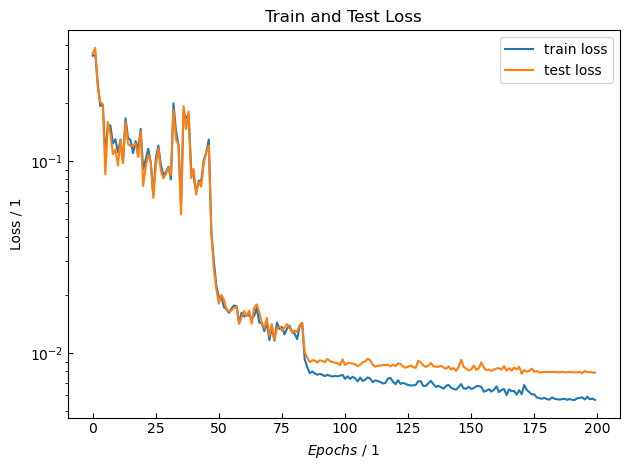

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_011.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999289967944707 , R^2(NH3) = 0.999845698712498
Test Dataset: R^2(H2) = 0.9999105513871086 , R^2(NH3) = 0.9998200042394672
Max Error Training: |x_H2 - x_H2,pred| = 0.021005461953421622 , |x_NH3 - x_NH3,pred| = 0.011625194969544006
Max Error Test: |x_H2 - x_H2,pred| = 0.005651819568395722 , |x_NH3 - x_NH3,pred| = 0.008867787358143725


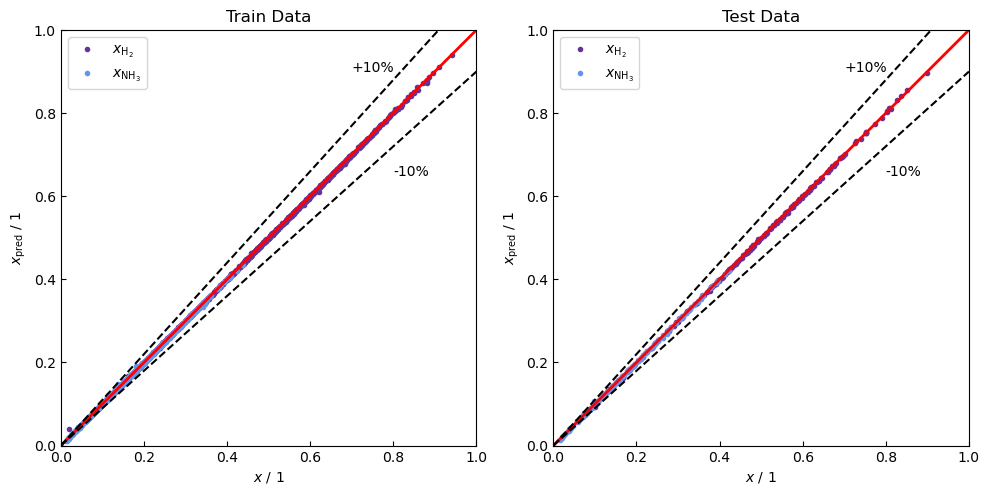

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

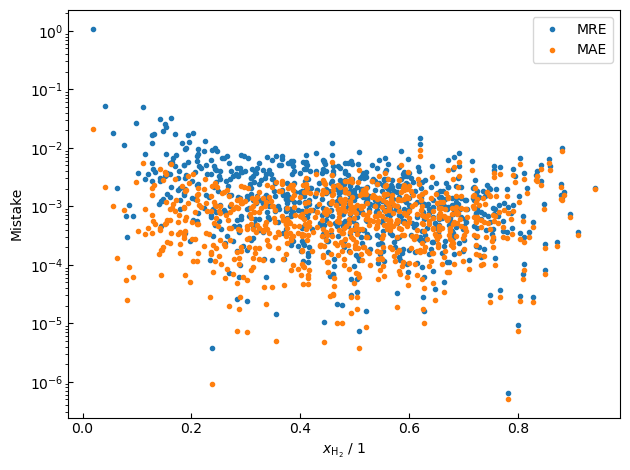

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

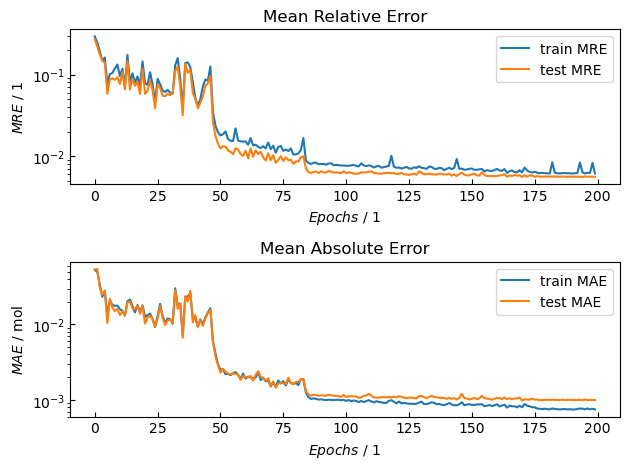

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

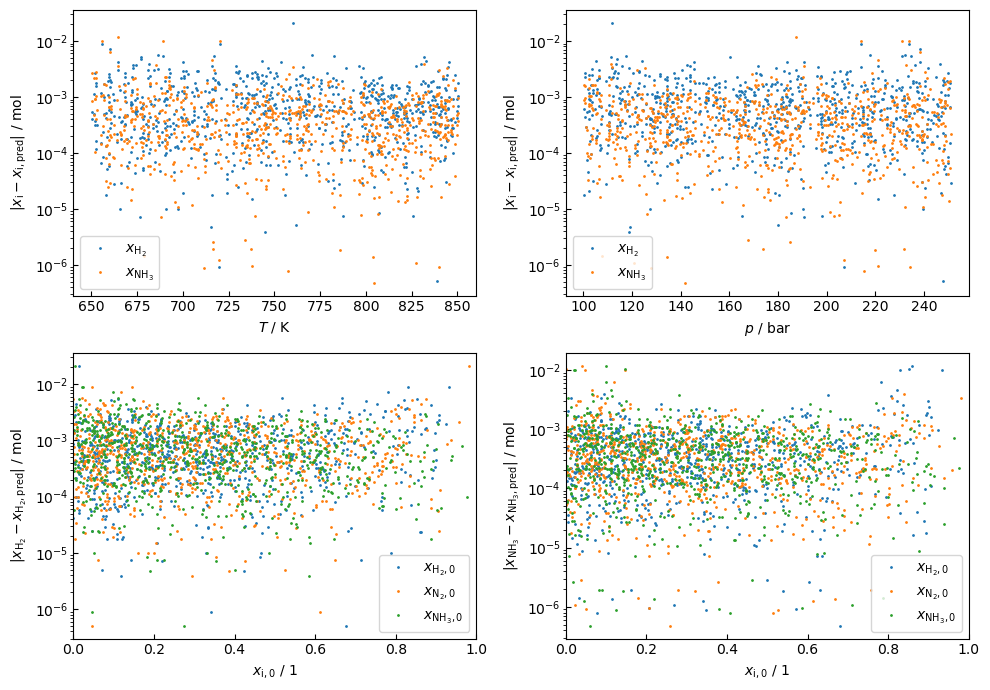

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

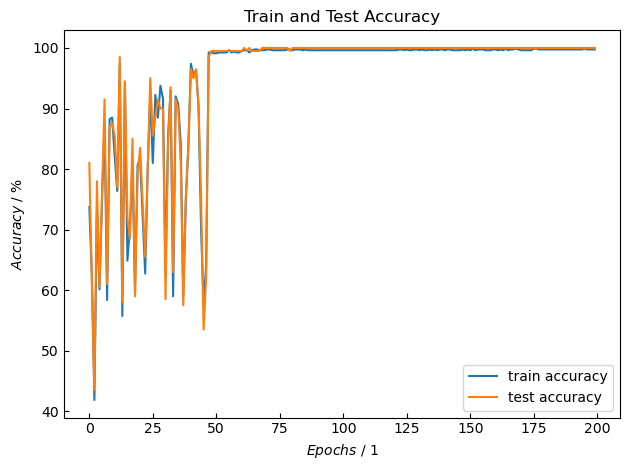

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.5360e+00, -1.7099e+00, -8.1444e-01, -1.3021e+00,  2.1301e+00],
        [-8.9452e-01, -6.9279e-02, -7.7655e-01,  2.1134e+00, -1.3979e+00],
        [-1.4898e-01,  2.4299e-02, -5.3808e-01, -3.0838e-01,  8.4325e-01],
        [-7.2814e-01, -1.4142e+00,  2.4807e-01,  6.1483e-01, -8.7185e-01],
        [-1.4830e+00,  9.4015e-01, -3.4571e-03, -1.1798e+00,  1.2093e+00],
        [ 9.6918e-01,  1.4529e+00,  1.0118e+00, -1.3698e+00,  4.0700e-01],
        [-7.2955e-02, -1.4348e+00,  1.8731e+00, -1.0964e+00, -7.1758e-01],
        [ 8.3015e-01,  5.8091e-01, -1.1633e+00, -7.5824e-01,  1.9166e+00],
        [ 1.0139e+00, -4.1590e-01, -5.6929e-01,  1.8430e+00, -1.3250e+00],
        [-1.1546e+00, -1.0749e+00,  1.0006e+00,  2.3159e-01, -1.2187e+00],
        [-1.5820e-01, -9.7309e-04,  4.7619e-01, -1.1607e-01, -3.4870e-01],
        [-1.4742e+00, -1.6396e+00, -5.7874e-01, -2.6831e-01,  8.4219e-01],
        [ 1.2629e+00, -1.3835e+00, -4.1635e-01, -9.2139e-02,  5.0278e-01],
        [-7.0648e-02,  5.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 1.0253e-01, -1.7768e-02,  4.2759e-02,  8.4822e-02,  4.3574e-02],
         [ 4.2788e-03, -9.8166e-02, -1.7674e-01, -1.8628e-01,  4.2399e-02],
         [-5.7962e-02, -2.4451e-02,  1.6201e-01,  2.8606e-01,  1.4374e-01],
         [-3.0599e-02,  2.2171e-02, -6.0834e-02, -4.6208e-02, -4.6413e-02],
         [ 1.9335e-01,  8.7456e-02,  1.7391e-01,  2.5080e-01, -4.1332e-02],
         [-2.6856e-02,  2.6385e-02,  1.7596e-01, -3.5318e-01, -2.1190e-01],
         [-1.0252e-01, -9.3045e-02,  2.8391e-01,  3.2733e-01,  2.8181e-01],
         [-5.5459e-02, -1.1255e-02,  1.8037e-01,  1.2666e-01,  1.5548e-01],
         [-3.1566e-01,  1.5102e-01, -2.5547e-01, -2.2728e-01,  1.8129e-01],
         [ 5.1514e-02,  5.2183e-02, -3.1282e-01, -2.5838e-01, -3.5647e-01],
         [ 1.3045e-01, -1.1023e-02, -2.2778e-01,  3.8728e-02, -2.2576e-01],
         [-1.5555e-01,  1.6541e-01, -2.2475e-01, -1.4246e-01,  7.9031e-02],
         [ 1.7718e-01, -4.6165e-02, -4.5703e-01,  3.9442e-01,  3.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8435, 0.6572, 0.7452, 0.8606, 0.3916],
        [0.9503, 0.7961, 0.4481, 0.7385, 0.4709]])
tensor([[ 0.0429, -0.3773],
        [ 0.0506, -0.4206]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.1012e-01, -1.0523e+00,  8.4818e-01, -5.1372e-01, -3.0734e-01],
        [-8.0487e-01, -1.4530e+00, -1.4150e+00, -2.8776e-01,  1.6828e+00],
        [ 1.1307e+00,  1.3079e+00,  2.6549e-01, -3.0853e-01,  5.4794e-02],
        [ 1.1156e+00,  3.4546e-01,  1.9729e-01, -1.1805e+00,  1.0130e+00],
        [ 1.1547e-01,  6.1207e-01, -1.1671e+00,  5.4298e-01,  5.9046e-01],
        [ 1.3808e-01, -7.5407e-01,  6.6335e-01, -1.2862e+00,  6.6355e-01],
        [-4.4606e-01, -1.2031e+00, -1.4157e+00,  2.1154e+00, -7.7283e-01],
        [-2.3794e-01,  1.8205e-01, -2.5123e-01,  4.2145e-01, -1.8420e-01],
        [ 1.6101e+00,  7.9325e-01,  1.0182e+00, -5.2255e-01, -4.6513e-01],
        [ 1.4650e-01, -1.1116e+00, -7.3421e-01,  3.9395e-01,  3.1789e-01],
        [-1.0546e+00, -1.1501e+00,  2.1388e+00, -9.5560e-01, -1.1223e+00],
        [-6.1863e-01, -6.0208e-01, -4.2254e-01,  2.3183e-01,  1.7773e-01],
        [ 1.4976e+00, -1.7380e-01, -1.2216e+00, -5.2286e-01,  1.7332e+00],
        [-1.5536e+00, -9.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()